In [36]:
import pandas as pd
import seaborn as sns

from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
DATA_PATH = Path(Path.cwd(), "data")

split_fraction = 0.7
stock_id_col = "PERMNO"
feature_cols = [
    "marketCapitalization", "momentum", "beta", "idiosyncraticVolatility", "bm", "ps",
    "pcf", "dpr", "roe", "GProf", "capital_ratio", "invt_act", "debt_ebitda", "fcf_ocf",
    "de_ratio", "cash_ratio", "at_turn", "rd_sale", "staff_sale", "PEG_trailing"
]
target_col = "returns"
cutoff_train = 1987
cutoff_valid = 1997
start_year = 1997
max_year = 2021

In [31]:
def impute_na(df, feature_cols, group_col, how="mean"):
    df_imp = df.copy()

    if how == "mean":
        for target in feature_cols:
            df_imp[target] = df_imp.groupby(group_col)[target].transform(
                lambda x: x.fillna(x.mean())
            )
    elif how == "median":
        for target in feature_cols:
            df_imp[target] = df_imp.groupby(group_col)[target].transform(
                lambda x: x.fillna(x.median())
            )
    else:
        for target in feature_cols:
            df_imp[target] = df_imp.groupby(group_col)[target].transform(
                lambda x: x.fillna(0)
            )

    df_imp.dropna(inplace=True)
    return df_imp.reset_index(drop=True)


def split_X_y(df, feature_cols, target_col):
    X = df[feature_cols]
    y = df[target_col]
    return X, y

In [32]:
df_stock = pd.read_csv(DATA_PATH / "US Stock Data.csv", parse_dates=[1])
imputer = FunctionTransformer(impute_na, kw_args={"feature_cols": feature_cols, "group_col": stock_id_col})
splitter = FunctionTransformer(split_X_y, kw_args={"feature_cols": feature_cols, "target_col": target_col})

In [33]:
df_stock.head()

,PERMNO,date,returns,marketCapitalization,momentum,beta,idiosyncraticVolatility,bm,ps,pcf,dpr,roe,GProf,capital_ratio,invt_act,debt_ebitda,fcf_ocf,de_ratio,cash_ratio,at_turn,rd_sale,staff_sale,PEG_trailing
0,10001,1989-02-28,0.038462,6736500.0,0.093370,0.074046,0.040948,1.213,0.377,13.609,0.0,0.124,0.148,0.416,0.039,2.270,0.618,1.702,0.309,1.210,0.0,0.0,NaN
1,10001,1989-03-31,0.017778,6736500.0,0.032231,0.062942,0.041283,1.213,0.377,13.609,0.0,0.124,0.148,0.416,0.039,2.270,0.618,1.702,0.309,1.210,0.0,0.0,0.018
2,10001,1989-04-28,0.074074,7235500.0,0.160472,0.058639,0.041240,1.213,0.404,14.617,0.0,0.124,0.148,0.416,0.039,2.270,0.618,1.702,0.309,1.210,0.0,0.0,0.020
3,10001,1989-05-31,-0.034483,6986000.0,0.146021,0.078721,0.042557,1.231,0.337,5.558,0.0,0.136,0.155,0.475,0.040,2.396,0.618,1.938,0.324,1.253,0.0,0.0,0.025
4,10001,1989-06-30,0.017143,7007000.0,0.207010,0.075193,0.043107,1.231,0.338,5.574,0.0,0.136,0.155,0.475,0.040,2.396,0.618,1.938,0.324,1.253,0.0,0.0,0.025


In [42]:
model = RandomForestRegressor(n_estimators=100, max_depth=3, max_features="sqrt")
val_r2 = {}
pred_list = []
true_list = []

In [36]:
for i in tqdm(range(cutoff_train, max_year)):
    df_stock["tag"] = df_stock.date.map(lambda x: "train" if x.year<cutoff_train else ("valid" if x.year<cutoff_valid else "test"))
    train = df_stock[df_stock["tag"]=="train"].drop(["tag"], axis=1)
    validation = df_stock[df_stock["tag"]=="valid"].drop(["tag"], axis=1)
    test = df_stock[df_stock["tag"]=="test"].drop(["tag"], axis=1)
    test_next = test[test.date.dt.year==cutoff_valid].reset_index(drop=True)

    train = imputer.fit_transform(train)
    validation = imputer.fit_transform(validation)
    test_next = imputer.fit_transform(test_next)

    X_train, y_train = splitter.fit_transform(train)
    X_valid, y_valid = splitter.fit_transform(validation)
    X_test_next, y_test_next = splitter.fit_transform(test_next)

    model.fit(X_train, y_train)
    val_r2[cutoff_valid] = model.score(X_test_next, y_test_next)
    pred_list.append(list(model.predict(X_test_next)))
    true_list.append(list(y_test_next))
    cutoff_train += 1
    cutoff_valid += 1

In [43]:
# df_stock["tag"] = df_stock.date.map(lambda x: "train" if x.year<cutoff_train else ("valid" if x.year<cutoff_valid else "test"))
# train = df_stock[df_stock["tag"]=="train"].drop(["tag"], axis=1)
# validation = df_stock[df_stock["tag"]=="valid"].drop(["tag"], axis=1)
# test = df_stock[df_stock["tag"]=="test"].drop(["tag"], axis=1)
# test_next = test[test.date.dt.year==cutoff_valid].reset_index(drop=True)

# train = imputer.fit_transform(train)
# validation = imputer.fit_transform(validation)
# test_next = imputer.fit_transform(test_next)

# X_train, y_train = splitter.fit_transform(train)
# X_valid, y_valid = splitter.fit_transform(validation)
# X_test_next, y_test_next = splitter.fit_transform(test_next)

# model.fit(X_train, y_train)
# val_r2[cutoff_valid] = model.score(X_test_next, y_test_next)
# pred_list.append(list(model.predict(X_test_next)))
# true_list.append(list(y_test_next))
# cutoff_train += 1
# cutoff_valid += 1

In [44]:
y_pred = [item for sublist in pred_list for item in sublist]
y_true = [item for sublist in true_list for item in sublist]

overall_r2 = r2_score(y_true, y_pred)

In [60]:
model.feature_importances_

array([0.1462595 , 0.04646682, 0.0240271 , 0.03384424, 0.25836993,
       0.25262241, 0.08933282, 0.00135708, 0.02177801, 0.01180084,
       0.00748861, 0.00205772, 0.00788697, 0.00941209, 0.01183597,
       0.00422405, 0.05262389, 0.00371293, 0.0014107 , 0.01348833])

<AxesSubplot:>

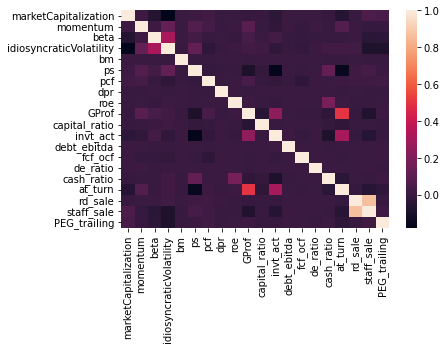

In [65]:
sns.heatmap(X_train.corr())